# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop

import datetime
import pytz

We set the random seed so that the results don't vary drastically.

In [ ]:
from keras import backend as K
import tensorflow as tf

from numpy.random import seed
seed(23)
tf.random.set_seed(23)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/val.csv').readlines())
batch_size = 32

In [ ]:
train_doc[:3]

array(['WIN_20180907_16_56_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_27_33_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_26_40_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'],
      dtype='<U88')

Checking the overall image size.

In [ ]:
source_path= '/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train'
indi_file= [(source_path + '/' + x.split(';')[0]) for x in train_doc]
img_shape=[]
for x in indi_file:
  imgs= os.listdir(x)
  for img in imgs:
    im= io.imread(x+'/'+ img)
    img_shape.append(im.shape)
    break
print(set(img_shape))

{(120, 160, 3), (360, 360, 3)}


As we could visualize there are two type of images

(120,160,3) & (360,360,3)

Plotting an image.

(360, 360, 3)


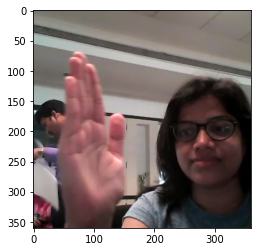

In [ ]:
import matplotlib.pyplot as plt
imgg= '/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00064.png'
pre= io.imread(imgg)
plt.imshow(pre)
print(pre.shape)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
img_idx = [0,3,6,9,11,12,15,18,21,24,27,29]
def generator(source_path, folder_list, batch_size, ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if ablation is not None:
      folder_list= folder_list[:(ablation)]
    while True:
        t = np.random.permutation(folder_list)
        x= len(img_idx)
        y,z= 120,120
        num_batches = int(np.floor(len(t)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # img_idx is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape== (360,360,3):
                      image= crop(image, ((40,20),(30,30),(0,0)),copy=False)
                    resized_image= resize(image, (y,z))
                    batch_data[folder,idx,:,:,:] = np.float32(resized_image/255)
                    #batch_data[folder,idx,:,:,0] = (resized_image[:,:,0] - np.min(resized_image[:,:,0]))/(np.max(resized_image[:,:,0]) - np.min(resized_image[:,:,0]))
                    #batch_data[folder,idx,:,:,1] = (resized_image[:,:,1] - np.min(resized_image[:,:,1]))/(np.max(resized_image[:,:,1]) - np.min(resized_image[:,:,1]))
                    #batch_data[folder,idx,:,:,2] = (resized_image[:,:,2] - np.min(resized_image[:,:,2]))/(np.max(resized_image[:,:,2]) - np.min(resized_image[:,:,2]))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rest_data = len(t) % (batch_size)
        batch_data = np.zeros((rest_data,x,y,z,3)) # img_idx is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((rest_data,5))
        for i in range(rest_data):
          imgs= os.listdir(source_path+'/'+ t[-(rest_data-i)].split(';')[0])
          for idx,item in enumerate(img_idx):
            image = io.imread(source_path+'/'+ t[-(rest_data-i)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape== (360,360,3):
              image= crop(image, ((40,20),(30,30),(0,0)),copy=False)
            resized_image= resize(image, (y,z))
            batch_data[i,idx,:,:,:] = np.float32(resized_image/255)
            #batch_data[i,idx,:,:,0] = (resized_image[:,:,0] - np.min(resized_image[:,:,0]))/(np.max(resized_image[:,:,0]) - np.min(resized_image[:,:,0]))
            #batch_data[i,idx,:,:,1] = (resized_image[:,:,1] - np.min(resized_image[:,:,1]))/(np.max(resized_image[:,:,1]) - np.min(resized_image[:,:,1]))
            #batch_data[i,idx,:,:,2] = (resized_image[:,:,2] - np.min(resized_image[:,:,2]))/(np.max(resized_image[:,:,2]) - np.min(resized_image[:,:,2]))
          batch_labels[i, int(t[-(rest_data-i)].strip().split(';')[2])] = 1
          
        yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches


In [ ]:
train_path = '/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train'
val_path = '/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/val'

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Reshape, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, AveragePooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [ ]:
def compile_model(model,epoch=20, ablation=None, learning_rate=0.001, store_model=False):
  optimiser = optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  
  train_generator = generator(train_path, train_doc, batch_size)
  if ablation is not None:
    train_generator = generator(train_path, train_doc, batch_size, ablation=ablation)
  val_generator = generator(val_path, val_doc, batch_size)

  num_train_sequences = len(train_doc)
  if ablation is not None:
    num_train_sequences = ablation
  num_val_sequences = len(val_doc)
  
  LR = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, verbose=0, 
                         mode='auto',min_delta=0.002, cooldown=0,min_lr=0)
  callbacks_list = [LR]

  if store_model==True:
    curr_dt_time= datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
    model_name = '/content/gdrive/MyDrive/Colab Notebooks/Gesture CS/'+'model_init_' + str(curr_dt_time).split('.')[0] + '/'
    if not os.path.exists(model_name):
      os.mkdir(model_name)
      filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
      checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
      callbacks_list= [LR, checkpoint]


  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = int(num_val_sequences//batch_size) + 1
  
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, workers=1, initial_epoch=0)

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(256, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 12, 120, 120, 64)  5248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 120, 120, 64)  256       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 12, 120, 120, 64)  110656    
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 120, 120, 64)  256       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 60, 60, 64)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 60, 60, 128)    221312    
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 60, 60, 128)   

We are taking only 100 data points from train dataset in order to know whether our model training is happening or not.

Let us now fit the model. This will start training the model on only ablation data to check the model is learning or not.

In [ ]:
compile_model(model, ablation=100, epoch=5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/5
4/4 [==============================] - 491s 163s/step - loss: 70.1439 - categorical_accuracy: 0.2175 - val_loss: 627.0288 - val_categorical_accuracy: 0.2100
Epoch 2/5
4/4 [==============================] - 30s 10s/step - loss: 83.5123 - categorical_accuracy: 0.1555 - val_loss: 10996.7930 - val_categorical_accuracy: 0.2000
Epoch 3/5
4/4 [==============================] - 29s 9s/step - loss: 16.0776 - categorical_accuracy: 0.4230 - val_loss: 18155.1133 - val_categorical_accuracy: 0.2400
Epoch 4/5
4/4 [==============================] - 26s 8s/step - loss: 7.9608 - categorical_accuracy: 0.5613 - val_loss: 9183.2939 - val_categorical_accuracy: 0.1900
Epoch 5/5
4/4 [==============================] - 29s 9s/step - loss: 6.0951 - categorical_accuracy: 0.6015 - val_loss: 5457.7808 - val_categorical_accuracy: 0.1800


Now will run the model with entire dataset with 20 epochs.

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(32, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 12, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 120, 120, 32)  128       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 12, 120, 120, 32)  27680     
_________________________________________________________________
batch_normalization_13 (Batc (None, 12, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 60, 60, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 6, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_14 (Batc (None, 6, 60, 60, 64)    

In [ ]:
compile_model(model, epoch=20, store_model=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 99s 5s/step - loss: 25.5032 - categorical_accuracy: 0.3020 - val_loss: 732.1545 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 732.15454, saving model to /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/model_init_2021-01-30 01:41:47/model-00001-14.82004-0.36048-732.15454-0.21000.h5
Epoch 2/20
21/21 [==============================] - 95s 5s/step - loss: 1.6901 - categorical_accuracy: 0.5018 - val_loss: 158.0536 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss improved from 732.15454 to 158.05363, saving model to /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/model_init_2021-01-30 01:41:47/model-00002-1.44145-0.52338-158.05363-0.18000.h5
Epoch 3/20
21/21 [==============================] - 96s 5s/step - loss: 0.8735 - categorical_accuracy: 0.6739 - val_loss: 49.1853 - val_cate

Let us run the model with Averagepooling rather than Max pooling.

In [ ]:
num_class=5

model= Sequential()
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(16, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(64, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu', input_shape= (len(img_idx),120,120,3)))
model.add(BatchNormalization())
model.add(Conv3D(128, (3,3,3), padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation= 'relu'))
model.add(Dropout(0.4))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 12, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_18 (Batc (None, 12, 120, 120, 16)  64        
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 12, 120, 120, 16)  6928      
_________________________________________________________________
batch_normalization_19 (Batc (None, 12, 120, 120, 16)  64        
_________________________________________________________________
average_pooling3d (AveragePo (None, 6, 60, 60, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 6, 60, 60, 64)    

In [ ]:
compile_model(model, epoch=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 2360s 117s/step - loss: 9.2072 - categorical_accuracy: 0.3086 - val_loss: 15.5596 - val_categorical_accuracy: 0.2500
Epoch 2/20
21/21 [==============================] - 92s 5s/step - loss: 1.7640 - categorical_accuracy: 0.4231 - val_loss: 8.8267 - val_categorical_accuracy: 0.2900
Epoch 3/20
21/21 [==============================] - 90s 4s/step - loss: 1.0911 - categorical_accuracy: 0.5337 - val_loss: 1.4608 - val_categorical_accuracy: 0.3900
Epoch 4/20
21/21 [==============================] - 89s 4s/step - loss: 0.9668 - categorical_accuracy: 0.5843 - val_loss: 1.6219 - val_categorical_accuracy: 0.3500
Epoch 5/20
21/21 [==============================] - 90s 4s/step - loss: 0.6923 - categorical_accuracy: 0.7356 - val_loss: 1.8074 - val_categorical_accuracy: 0.3400
Epoch 6/20
21/21 [==============================] - 92s 5s/step - loss: 0.5317 - categorical_accuracy: 0.8287 - val_loss: 1.5900 - val_categorical_accuracy: 0.4600
Epoch 7/20


Now let's build a CNN+RNN model using ResNet architecture.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(256, return_sequences=True))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 32768)         0         
_________________________________________________________________
gru (GRU)                    (None, 12, 256)           25363968  
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 49,345,669
Trainable params: 25,757,957
N

In [ ]:
compile_model(model, epoch=7, ablation=200 )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/7
7/7 [==============================] - 44s 7s/step - loss: 8.9734 - categorical_accuracy: 0.2206 - val_loss: 2.4863 - val_categorical_accuracy: 0.2100
Epoch 2/7
7/7 [==============================] - 38s 6s/step - loss: 4.0136 - categorical_accuracy: 0.1841 - val_loss: 3.1040 - val_categorical_accuracy: 0.2300
Epoch 3/7
7/7 [==============================] - 37s 6s/step - loss: 3.3923 - categorical_accuracy: 0.1888 - val_loss: 3.2470 - val_categorical_accuracy: 0.2100
Epoch 4/7
7/7 [==============================] - 34s 6s/step - loss: 3.6895 - categorical_accuracy: 0.2282 - val_loss: 2.7638 - val_categorical_accuracy: 0.1800
Epoch 5/7
7/7 [==============================] - 38s 6s/step - loss: 2.3836 - categorical_accuracy: 0.2507 - val_loss: 2.0845 - val_categorical_accuracy: 0.2100
Epoch 6/7
7/7 [==============================] - 37s 6s/step - loss: 1.8709 - c

Now when the model is running fine, we will try different parametres to boost the accuracy

We start with the below architecture with intentionally skipping the save model callback.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(1024, return_sequences=True))
model.add(GRU(1024, return_sequences=False))
model.add(Dense(512))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 12, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 32768)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 1024)          103815168 
_________________________________________________________________
gru_2 (GRU)                  (None, 1024)              6297600   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 134,227,845
Trainable params: 110,640,133
Non-trainable params: 23,587,712
_______________________________

Now we will run the model for 20 epochs.

In [ ]:
compile_model(model, epoch=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 98s 5s/step - loss: 7.6492 - categorical_accuracy: 0.2099 - val_loss: 3.4170 - val_categorical_accuracy: 0.2200
Epoch 2/20
21/21 [==============================] - 90s 4s/step - loss: 2.6766 - categorical_accuracy: 0.1937 - val_loss: 2.1922 - val_categorical_accuracy: 0.1900
Epoch 3/20
21/21 [==============================] - 89s 4s/step - loss: 2.0718 - categorical_accuracy: 0.2054 - val_loss: 1.9693 - val_categorical_accuracy: 0.1200
Epoch 4/20
21/21 [==============================] - 86s 4s/step - loss: 1.8474 - categorical_accuracy: 0.2119 - val_loss: 1.6605 - val_categorical_accuracy: 0.3000
Epoch 5/20
21/21 [==============================] - 89s 4s/step - loss: 1.8075 - categorical_accuracy: 0.2034 - val_loss: 2.2659 - val_categorical_accuracy: 0.1600
Epoch 6/20
21/21 [==============================] - 88s 4s/step 

Now we will try with a different architecture as the above model accuracy is very low.

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(2048, return_sequences=True))
model.add(Dense(1024))
model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 12, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 12, 32768)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 2048)          213921792 
_________________________________________________________________
dense_12 (Dense)             (None, 12, 1024)          2098176   
_________________________________________________________________
flatten_8 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 61445     
Total params: 239,669,125
Trainable params: 216,081,413
Non-trainable params: 23,587,712
_______________________________

In [ ]:
compile_model(model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 97s 5s/step - loss: 15.3634 - categorical_accuracy: 0.2356 - val_loss: 3.4242 - val_categorical_accuracy: 0.1600
Epoch 2/20
21/21 [==============================] - 90s 4s/step - loss: 3.2244 - categorical_accuracy: 0.2068 - val_loss: 2.3837 - val_categorical_accuracy: 0.1100
Epoch 3/20
21/21 [==============================] - 91s 5s/step - loss: 2.0765 - categorical_accuracy: 0.2084 - val_loss: 1.9744 - val_categorical_accuracy: 0.2100
Epoch 4/20
21/21 [==============================] - 87s 4s/step - loss: 1.8449 - categorical_accuracy: 0.2210 - val_loss: 1.5358 - val_categorical_accuracy: 0.3400
Epoch 5/20
21/21 [==============================] - 90s 4s/step - loss: 1.5410 - categorical_accuracy: 0.2710 - val_loss: 1.4327 - val_categorical_accuracy: 0.3400
Epoch 6/20
21/21 [==============================] - 90s 4s/step

In [ ]:
num_class=5

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= (120,120,3))
    
# freeze the layers in base model
for layer in base_model.layers:
  layer.trainable = False

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(2048, return_sequences=True))
model.add(GRU(2048, return_sequences=False))
model.add(Dense(1024))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 12, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 12, 32768)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 12, 2048)          213921792 
_________________________________________________________________
gru_5 (GRU)                  (None, 2048)              25178112  
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 5125      
Total params: 264,790,917
Trainable params: 241,203,205
Non-trainable params: 23,587,712
_______________________________

In [ ]:
compile_model(model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 98s 5s/step - loss: 17.2078 - categorical_accuracy: 0.2082 - val_loss: 3.3721 - val_categorical_accuracy: 0.2200
Epoch 2/20
21/21 [==============================] - 90s 4s/step - loss: 3.4219 - categorical_accuracy: 0.1590 - val_loss: 3.0992 - val_categorical_accuracy: 0.2000
Epoch 3/20
21/21 [==============================] - 92s 5s/step - loss: 2.9637 - categorical_accuracy: 0.1807 - val_loss: 2.5347 - val_categorical_accuracy: 0.2000
Epoch 4/20
21/21 [==============================] - 87s 4s/step - loss: 2.6807 - categorical_accuracy: 0.2345 - val_loss: 3.4231 - val_categorical_accuracy: 0.1700
Epoch 5/20
21/21 [==============================] - 91s 5s/step - loss: 3.0751 - categorical_accuracy: 0.2288 - val_loss: 3.4021 - val_categorical_accuracy: 0.2300
Epoch 6/20
21/21 [==============================] - 91s 5s/step

We will now try with one last model.

In [ ]:
num_class=5

base_model= Sequential()
base_model.add(Conv2D(32, (3,3), padding= 'same', activation='relu'))
base_model.add(Conv2D(64, (3,3), padding= 'same', activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(BatchNormalization())
base_model.add(Dropout(0.25))

base_model.add(Conv2D(64, (3,3), padding= 'same', activation='relu'))
base_model.add(Conv2D(64, (3,3), padding= 'same', activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(BatchNormalization())
base_model.add(Dropout(0.25))

model= Sequential()
model.add(TimeDistributed(base_model, input_shape=(len(img_idx),120,120,3)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(512, return_sequences=True))
#model.add(GRU(512, return_sequences=False))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.4))
model.add(Dense(num_class, activation='softmax'))

print (model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 12, 30, 30, 64)    93760     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 12, 57600)         0         
_________________________________________________________________
gru_14 (GRU)                 (None, 12, 512)           89263104  
_________________________________________________________________
flatten_16 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               1573120   
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)               

In [ ]:
compile_model(model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Gesture CS/Project_data/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 97s 5s/step - loss: 5.4538 - categorical_accuracy: 0.3344 - val_loss: 14.0932 - val_categorical_accuracy: 0.2400
Epoch 2/20
21/21 [==============================] - 96s 5s/step - loss: 3.3320 - categorical_accuracy: 0.5080 - val_loss: 7.0793 - val_categorical_accuracy: 0.2800
Epoch 3/20
21/21 [==============================] - 95s 5s/step - loss: 2.1556 - categorical_accuracy: 0.6092 - val_loss: 8.6924 - val_categorical_accuracy: 0.2000
Epoch 4/20
21/21 [==============================] - 92s 5s/step - loss: 1.4485 - categorical_accuracy: 0.7199 - val_loss: 7.8818 - val_categorical_accuracy: 0.2300
Epoch 5/20
21/21 [==============================] - 95s 5s/step - loss: 0.9416 - categorical_accuracy: 0.7604 - val_loss: 7.1052 - val_categorical_accuracy: 0.2600
Epoch 6/20
21/21 [==============================] - 96s 5s/step